# Image classification

In [1]:
import torch
from torch import Generator

# Set the random seed for reproducibility
random_state = 42

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Preprocessing

In [3]:
import os
from data import train_val_split

base_dir = './data/train'
train_dir = './data/preprocessed/train'
val_dir = './data/preprocessed/val'

val_ratio = 0.2

if not os.path.exists(train_dir) and not os.path.exists(val_dir):
    train_val_split(base_dir, train_dir, val_dir, val_ratio, random_state) 

    print("Saved train data to:", train_dir)
    print("Saved validation data to:", val_dir)
else:
    print("Train and validation directories already exist.")

Train and validation directories already exist.


## Data

In [4]:
import torchvision.transforms as transforms

mean_tensor = torch.tensor([0.5, 0.5, 0.5])
std_tensor = torch.tensor([0.5, 0.5, 0.5])

# mean_tensor = torch.tensor([0.5209, 0.4955, 0.4384])
# std_tensor = torch.tensor([0.2111, 0.2103, 0.2101])

default_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_tensor, std_tensor)
])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean_tensor, std_tensor)
])

### Datasets and sampling

In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from data import sample_dataset

train_default_ds = ImageFolder(train_dir, transform=default_transform)
train_augmented_ds = ImageFolder(train_dir, transform=augmented_transform)
train_ds = ConcatDataset([train_default_ds, train_augmented_ds])

val_ds = ImageFolder(val_dir, transform=default_transform)

# downsample the dataset
sample_ratio = 1
sampled_train_ds = sample_dataset(train_ds, sample_ratio, seed=random_state)
sampled_val_ds = sample_dataset(val_ds, sample_ratio, seed=random_state)

num_classes = len(train_default_ds.classes)

print(f"Number of training samples: {len(sampled_train_ds)}")
print(f"Number of validation samples: {len(sampled_val_ds)}")

Number of training samples: 140818
Number of validation samples: 17602


### Data loaders

In [6]:
batch_size = 256
num_workers = 0

# setup data loaders
train_dl = DataLoader(sampled_train_ds,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      shuffle=True,
                      generator=Generator().manual_seed(random_state))

val_dl = DataLoader(sampled_val_ds,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=False)

### Example

Sample image shape: torch.Size([3, 64, 64])
Sample label: 0


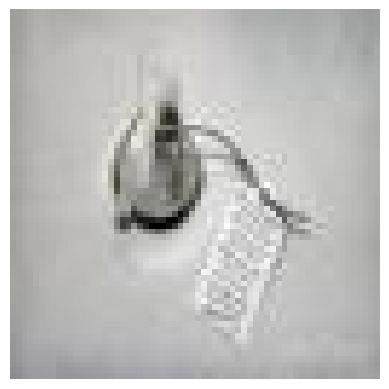

In [7]:
from utils import show_image

sample_img, sample_label = train_ds[0]

print(f"Sample image shape: {sample_img.size()}")
print(f"Sample label: {sample_label}")

show_image(sample_img)


## Training

In [8]:
from training import Trainer
import torch.optim as optim

### BasicModel

In [9]:
from models import BasicNet

basicNet = BasicNet(num_classes=num_classes)

optimizer = optim.Adam(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=50)

Epoch 1/50 (validation): 100%|██████████| 69/69 [04:51<00:00,  4.22s/it]


Epoch 1/50: Train Loss: 3.1975, Val Loss: 2.6314, Avg Class Accuracy: 0.2980


Epoch 2/50 (validation): 100%|██████████| 69/69 [03:41<00:00,  3.21s/it]


Epoch 2/50: Train Loss: 2.6930, Val Loss: 2.3056, Avg Class Accuracy: 0.3785


Epoch 3/50 (validation): 100%|██████████| 69/69 [03:46<00:00,  3.29s/it]


Epoch 3/50: Train Loss: 2.4777, Val Loss: 2.1555, Avg Class Accuracy: 0.4095


Epoch 4/50 (validation): 100%|██████████| 69/69 [04:18<00:00,  3.75s/it]


Epoch 4/50: Train Loss: 2.3423, Val Loss: 2.0635, Avg Class Accuracy: 0.4344


Epoch 5/50 (validation): 100%|██████████| 69/69 [01:12<00:00,  1.06s/it]


Epoch 5/50: Train Loss: 2.2412, Val Loss: 1.9764, Avg Class Accuracy: 0.4526


Epoch 6/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.74it/s]


Epoch 6/50: Train Loss: 2.1680, Val Loss: 1.9539, Avg Class Accuracy: 0.4627


Epoch 7/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.82it/s]


Epoch 7/50: Train Loss: 2.1045, Val Loss: 1.8550, Avg Class Accuracy: 0.4872


Epoch 8/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.73it/s]


Epoch 8/50: Train Loss: 2.0559, Val Loss: 1.8631, Avg Class Accuracy: 0.4850


Epoch 9/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.83it/s]


Epoch 9/50: Train Loss: 2.0099, Val Loss: 1.7911, Avg Class Accuracy: 0.5045


Epoch 10/50 (validation): 100%|██████████| 69/69 [00:17<00:00,  3.85it/s]


Epoch 10/50: Train Loss: 1.9668, Val Loss: 1.7395, Avg Class Accuracy: 0.5192


Epoch 11/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 11/50: Train Loss: 1.9296, Val Loss: 1.7159, Avg Class Accuracy: 0.5231


Epoch 12/50 (validation): 100%|██████████| 69/69 [00:23<00:00,  2.97it/s]


Epoch 12/50: Train Loss: 1.8968, Val Loss: 1.6782, Avg Class Accuracy: 0.5322


Epoch 13/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 13/50: Train Loss: 1.8613, Val Loss: 1.6796, Avg Class Accuracy: 0.5343


Epoch 14/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.62it/s]


Epoch 14/50: Train Loss: 1.8287, Val Loss: 1.6300, Avg Class Accuracy: 0.5455


Epoch 15/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.70it/s]


Epoch 15/50: Train Loss: 1.8080, Val Loss: 1.6446, Avg Class Accuracy: 0.5438


Epoch 16/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.70it/s]


Epoch 16/50: Train Loss: 1.7817, Val Loss: 1.6105, Avg Class Accuracy: 0.5497


Epoch 17/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 17/50: Train Loss: 1.7564, Val Loss: 1.5896, Avg Class Accuracy: 0.5605


Epoch 18/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.54it/s]


Epoch 18/50: Train Loss: 1.7390, Val Loss: 1.5692, Avg Class Accuracy: 0.5613


Epoch 19/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.54it/s]


Epoch 19/50: Train Loss: 1.7168, Val Loss: 1.5630, Avg Class Accuracy: 0.5650


Epoch 20/50 (validation): 100%|██████████| 69/69 [00:21<00:00,  3.16it/s]


Epoch 20/50: Train Loss: 1.6948, Val Loss: 1.5477, Avg Class Accuracy: 0.5677


Epoch 21/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 21/50: Train Loss: 1.6796, Val Loss: 1.5438, Avg Class Accuracy: 0.5698


Epoch 22/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 22/50: Train Loss: 1.6616, Val Loss: 1.5222, Avg Class Accuracy: 0.5737


Epoch 23/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 23/50: Train Loss: 1.6412, Val Loss: 1.4954, Avg Class Accuracy: 0.5810


Epoch 24/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 24/50: Train Loss: 1.6235, Val Loss: 1.5052, Avg Class Accuracy: 0.5771


Epoch 25/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 25/50: Train Loss: 1.6128, Val Loss: 1.4841, Avg Class Accuracy: 0.5881


Epoch 26/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 26/50: Train Loss: 1.5957, Val Loss: 1.4880, Avg Class Accuracy: 0.5865


Epoch 27/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 27/50: Train Loss: 1.5816, Val Loss: 1.4717, Avg Class Accuracy: 0.5860


Epoch 28/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch 28/50: Train Loss: 1.5673, Val Loss: 1.4759, Avg Class Accuracy: 0.5870


Epoch 29/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 29/50: Train Loss: 1.5549, Val Loss: 1.4822, Avg Class Accuracy: 0.5866


Epoch 30/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 30/50: Train Loss: 1.5414, Val Loss: 1.4462, Avg Class Accuracy: 0.5928


Epoch 31/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Epoch 31/50: Train Loss: 1.5294, Val Loss: 1.4426, Avg Class Accuracy: 0.5980


Epoch 32/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 32/50: Train Loss: 1.5187, Val Loss: 1.4450, Avg Class Accuracy: 0.5967


Epoch 33/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 33/50: Train Loss: 1.5063, Val Loss: 1.4363, Avg Class Accuracy: 0.5979


Epoch 34/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 34/50: Train Loss: 1.4932, Val Loss: 1.4097, Avg Class Accuracy: 0.6042


Epoch 35/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch 35/50: Train Loss: 1.4823, Val Loss: 1.4245, Avg Class Accuracy: 0.6009


Epoch 36/50 (validation): 100%|██████████| 69/69 [00:24<00:00,  2.82it/s]


Epoch 36/50: Train Loss: 1.4734, Val Loss: 1.3891, Avg Class Accuracy: 0.6103


Epoch 37/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.55it/s]


Epoch 37/50: Train Loss: 1.4627, Val Loss: 1.4298, Avg Class Accuracy: 0.6036


Epoch 38/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.54it/s]


Epoch 38/50: Train Loss: 1.4511, Val Loss: 1.3981, Avg Class Accuracy: 0.6077


Epoch 39/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.55it/s]


Epoch 39/50: Train Loss: 1.4402, Val Loss: 1.4015, Avg Class Accuracy: 0.6089


Epoch 40/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 40/50: Train Loss: 1.4333, Val Loss: 1.3995, Avg Class Accuracy: 0.6105


Epoch 41/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Epoch 41/50: Train Loss: 1.4269, Val Loss: 1.3966, Avg Class Accuracy: 0.6083


Epoch 42/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 42/50: Train Loss: 1.4137, Val Loss: 1.3685, Avg Class Accuracy: 0.6148


Epoch 43/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 43/50: Train Loss: 1.4070, Val Loss: 1.3773, Avg Class Accuracy: 0.6132


Epoch 44/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 44/50: Train Loss: 1.3951, Val Loss: 1.3464, Avg Class Accuracy: 0.6213


Epoch 45/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 45/50: Train Loss: 1.3900, Val Loss: 1.3517, Avg Class Accuracy: 0.6193


Epoch 46/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch 46/50: Train Loss: 1.3762, Val Loss: 1.3612, Avg Class Accuracy: 0.6155


Epoch 47/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch 47/50: Train Loss: 1.3679, Val Loss: 1.3599, Avg Class Accuracy: 0.6215


Epoch 48/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.56it/s]


Epoch 48/50: Train Loss: 1.3654, Val Loss: 1.3407, Avg Class Accuracy: 0.6229


Epoch 49/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 49/50: Train Loss: 1.3560, Val Loss: 1.3394, Avg Class Accuracy: 0.6222


Epoch 50/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.54it/s]

Epoch 50/50: Train Loss: 1.3465, Val Loss: 1.3286, Avg Class Accuracy: 0.6269


### Using AvgPool

In [12]:
from models import AVGPoolNet_Kernel5

basicNet = AVGPoolNet_Kernel5(num_classes=num_classes)

optimizer = optim.Adam(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=20)

Epoch 1/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 1/20: Train Loss: 3.5519, Val Loss: 3.1893, Avg Class Accuracy: 0.1791


Epoch 2/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 2/20: Train Loss: 3.2039, Val Loss: 2.9163, Avg Class Accuracy: 0.2359


Epoch 3/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.00it/s]


Epoch 3/20: Train Loss: 3.0018, Val Loss: 2.7232, Avg Class Accuracy: 0.2865


Epoch 4/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 4/20: Train Loss: 2.8473, Val Loss: 2.6173, Avg Class Accuracy: 0.3054


Epoch 5/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.91it/s]


Epoch 5/20: Train Loss: 2.7407, Val Loss: 2.5357, Avg Class Accuracy: 0.3214


Epoch 6/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.94it/s]


Epoch 6/20: Train Loss: 2.6482, Val Loss: 2.4430, Avg Class Accuracy: 0.3424


Epoch 7/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 7/20: Train Loss: 2.5674, Val Loss: 2.3899, Avg Class Accuracy: 0.3511


Epoch 8/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.02it/s]


Epoch 8/20: Train Loss: 2.4828, Val Loss: 2.4825, Avg Class Accuracy: 0.3355


Epoch 9/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 9/20: Train Loss: 2.4221, Val Loss: 2.3141, Avg Class Accuracy: 0.3703


Epoch 10/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.94it/s]


Epoch 10/20: Train Loss: 2.3714, Val Loss: 2.2475, Avg Class Accuracy: 0.3917


Epoch 11/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 11/20: Train Loss: 2.3183, Val Loss: 2.2660, Avg Class Accuracy: 0.3872


Epoch 12/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.06it/s]


Epoch 12/20: Train Loss: 2.2730, Val Loss: 2.1535, Avg Class Accuracy: 0.4097


Epoch 13/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]


Epoch 13/20: Train Loss: 2.2267, Val Loss: 2.1056, Avg Class Accuracy: 0.4186


Epoch 14/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]


Epoch 14/20: Train Loss: 2.1863, Val Loss: 2.0864, Avg Class Accuracy: 0.4259


Epoch 15/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.05it/s]


Epoch 15/20: Train Loss: 2.1445, Val Loss: 2.1005, Avg Class Accuracy: 0.4210


Epoch 16/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.04it/s]


Epoch 16/20: Train Loss: 2.1160, Val Loss: 2.0568, Avg Class Accuracy: 0.4305


Epoch 17/20 (training):  54%|█████▎    | 74/138 [00:28<00:24,  2.62it/s]


KeyboardInterrupt: 

In [10]:
from models import AVGPoolNet_Kernel3

basicNet = AVGPoolNet_Kernel3(num_classes=num_classes)

optimizer = optim.Adam(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=20)

Epoch 1/20 (validation): 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


Epoch 1/20: Train Loss: 3.6056, Val Loss: 3.2587, Avg Class Accuracy: 0.1653


Epoch 2/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.89it/s]


Epoch 2/20: Train Loss: 3.2894, Val Loss: 3.0086, Avg Class Accuracy: 0.2249


Epoch 3/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.03it/s]


Epoch 3/20: Train Loss: 3.1105, Val Loss: 2.8311, Avg Class Accuracy: 0.2505


Epoch 4/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 4/20: Train Loss: 2.9690, Val Loss: 2.7241, Avg Class Accuracy: 0.2778


Epoch 5/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.00it/s]


Epoch 5/20: Train Loss: 2.8552, Val Loss: 2.5964, Avg Class Accuracy: 0.3081


Epoch 6/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 6/20: Train Loss: 2.7637, Val Loss: 2.5547, Avg Class Accuracy: 0.3171


Epoch 7/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.89it/s]


Epoch 7/20: Train Loss: 2.6879, Val Loss: 2.4556, Avg Class Accuracy: 0.3433


Epoch 8/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 8/20: Train Loss: 2.6138, Val Loss: 2.3922, Avg Class Accuracy: 0.3509


Epoch 9/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.91it/s]


Epoch 9/20: Train Loss: 2.5552, Val Loss: 2.3663, Avg Class Accuracy: 0.3565


Epoch 10/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]


Epoch 10/20: Train Loss: 2.5071, Val Loss: 2.2936, Avg Class Accuracy: 0.3762


Epoch 11/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 11/20: Train Loss: 2.4516, Val Loss: 2.2685, Avg Class Accuracy: 0.3804


Epoch 12/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.99it/s]


Epoch 12/20: Train Loss: 2.4129, Val Loss: 2.2203, Avg Class Accuracy: 0.3916


Epoch 13/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.95it/s]


Epoch 13/20: Train Loss: 2.3655, Val Loss: 2.2525, Avg Class Accuracy: 0.3869


Epoch 14/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.94it/s]


Epoch 14/20: Train Loss: 2.3395, Val Loss: 2.2128, Avg Class Accuracy: 0.3902


Epoch 15/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.87it/s]


Epoch 15/20: Train Loss: 2.3060, Val Loss: 2.1868, Avg Class Accuracy: 0.4021


Epoch 16/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]


Epoch 16/20: Train Loss: 2.2720, Val Loss: 2.1091, Avg Class Accuracy: 0.4196


Epoch 17/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.90it/s]


Epoch 17/20: Train Loss: 2.2431, Val Loss: 2.1306, Avg Class Accuracy: 0.4175


Epoch 18/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 18/20: Train Loss: 2.2123, Val Loss: 2.1298, Avg Class Accuracy: 0.4178


Epoch 19/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 19/20: Train Loss: 2.1843, Val Loss: 2.0676, Avg Class Accuracy: 0.4377


Epoch 20/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]

Epoch 20/20: Train Loss: 2.1691, Val Loss: 2.0930, Avg Class Accuracy: 0.4242


#### Not using pooling

In [13]:
from models import No_PoolNet

basicNet = No_PoolNet(num_classes=num_classes)

optimizer = optim.Adam(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=30)

Epoch 1/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.34it/s]


Epoch 1/30: Train Loss: 3.6513, Val Loss: 3.3290, Avg Class Accuracy: 0.1511


Epoch 2/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.30it/s]


Epoch 2/30: Train Loss: 3.3556, Val Loss: 3.1075, Avg Class Accuracy: 0.1935


Epoch 3/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.15it/s]


Epoch 3/30: Train Loss: 3.1828, Val Loss: 2.9245, Avg Class Accuracy: 0.2326


Epoch 4/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.91it/s]


Epoch 4/30: Train Loss: 3.0407, Val Loss: 2.8046, Avg Class Accuracy: 0.2699


Epoch 5/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 5/30: Train Loss: 2.9307, Val Loss: 2.7194, Avg Class Accuracy: 0.2773


Epoch 6/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.05it/s]


Epoch 6/30: Train Loss: 2.8368, Val Loss: 2.6641, Avg Class Accuracy: 0.2851


Epoch 7/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.98it/s]


Epoch 7/30: Train Loss: 2.7550, Val Loss: 2.5602, Avg Class Accuracy: 0.3180


Epoch 8/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.99it/s]


Epoch 8/30: Train Loss: 2.6783, Val Loss: 2.4966, Avg Class Accuracy: 0.3262


Epoch 9/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 9/30: Train Loss: 2.6033, Val Loss: 2.4735, Avg Class Accuracy: 0.3338


Epoch 10/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.12it/s]


Epoch 10/30: Train Loss: 2.5440, Val Loss: 2.3983, Avg Class Accuracy: 0.3416


Epoch 11/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 11/30: Train Loss: 2.4882, Val Loss: 2.4008, Avg Class Accuracy: 0.3532


Epoch 12/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 12/30: Train Loss: 2.4311, Val Loss: 2.3477, Avg Class Accuracy: 0.3573


Epoch 13/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.93it/s]


Epoch 13/30: Train Loss: 2.3787, Val Loss: 2.3147, Avg Class Accuracy: 0.3634


Epoch 14/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 14/30: Train Loss: 2.3369, Val Loss: 2.3540, Avg Class Accuracy: 0.3623


Epoch 15/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.88it/s]


Epoch 15/30: Train Loss: 2.2836, Val Loss: 2.2616, Avg Class Accuracy: 0.3809


Epoch 16/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.98it/s]


Epoch 16/30: Train Loss: 2.2415, Val Loss: 2.2297, Avg Class Accuracy: 0.3918


Epoch 17/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.32it/s]


Epoch 17/30: Train Loss: 2.1964, Val Loss: 2.2054, Avg Class Accuracy: 0.3934


Epoch 18/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 18/30: Train Loss: 2.1603, Val Loss: 2.2154, Avg Class Accuracy: 0.3951


Epoch 19/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.89it/s]


Epoch 19/30: Train Loss: 2.1262, Val Loss: 2.2037, Avg Class Accuracy: 0.3871


Epoch 20/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 20/30: Train Loss: 2.0866, Val Loss: 2.1822, Avg Class Accuracy: 0.3980


Epoch 21/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.39it/s]


Epoch 21/30: Train Loss: 2.0529, Val Loss: 2.1814, Avg Class Accuracy: 0.4049


Epoch 22/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.04it/s]


Epoch 22/30: Train Loss: 2.0234, Val Loss: 2.1696, Avg Class Accuracy: 0.4034


Epoch 23/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.15it/s]


Epoch 23/30: Train Loss: 1.9774, Val Loss: 2.1546, Avg Class Accuracy: 0.4051


Epoch 24/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.90it/s]


Epoch 24/30: Train Loss: 1.9570, Val Loss: 2.1302, Avg Class Accuracy: 0.4103


Epoch 25/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]


Epoch 25/30: Train Loss: 1.9268, Val Loss: 2.1574, Avg Class Accuracy: 0.4118


Epoch 26/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.03it/s]


Epoch 26/30: Train Loss: 1.9028, Val Loss: 2.1213, Avg Class Accuracy: 0.4208


Epoch 27/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 27/30: Train Loss: 1.8780, Val Loss: 2.1505, Avg Class Accuracy: 0.4138


Epoch 28/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]


Epoch 28/30: Train Loss: 1.8506, Val Loss: 2.1272, Avg Class Accuracy: 0.4211


Epoch 29/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.20it/s]


Epoch 29/30: Train Loss: 1.8240, Val Loss: 2.1564, Avg Class Accuracy: 0.4191


Epoch 30/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.86it/s]

Epoch 30/30: Train Loss: 1.8038, Val Loss: 2.1300, Avg Class Accuracy: 0.4200


### Renset-like model

In [ ]:
from models import SimpleResNet

simpleResNet = SimpleResNet(num_classes=num_classes)

optimizer = optim.Adam(simpleResNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(simpleResNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=20)

### Four-block CNN

In [ ]:
from models import FourBlockCNN

fourBlockCNN = FourBlockCNN(num_classes=50)

optimizer = optim.Adam(fourBlockCNN.to(device).parameters(), lr=1e-3, weight_decay=1e-5)

trainer = Trainer(fourBlockCNN, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=30)

# Results:
# Without augmentation: Epoch 10/10: Train Loss: 2.2281, Val Loss: 2.4054, Avg Class Accuracy: 0.3387
# With augmentation: Epoch 10/10: Train Loss: 1.7477, Val Loss: 1.8611, Avg Class Accuracy: 0.4847

## Resnet18

Here we train the ResNet18 model on the dataset to see the state of the art performance.

In [ ]:
import torch.nn as nn

resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, num_classes)

resnet18 = resnet18.to(device)

optimizer = optim.Adam(resnet18.parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(resnet18, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=30)